In [106]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [78]:
# load dataset (note that dataset is seperated by ';' rather than usual ',')
# Set Date as index column and 
data = pd.read_csv('WindData.csv', sep = ';', index_col= 'Date', parse_dates=True, date_format="%d/%m/%Y %H:%M")
data


,Wind Production PZ_1,Wind Production PZ_2,Station1_WND,Station1_DD,Station2_WND,Station2_DD,Station3_WND,Station3_DD,Station4_WND,Station4_DD,...,Station8_WND,Station8_DD,Station9_WND,Station9_DD,Station10_WND,Station10_DD,Station11_WND,Station11_DD,Station12_WND,Station12_DD
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,"1396,847852","122,7055319","9,6",191,"6,1",179,7,224,"8,4",198,...,"12,4",199,"7,7",228,"6,1",195,"5,7",184,"10,2",202
2016-01-01 01:00:00,"1304,469541","105,1476672","9,8",188,"6,1",177,"6,6",227,"8,3",192,...,"13,2",197,"7,3",231,6,193,"5,3",185,"10,7",200
2016-01-01 02:00:00,"1201,416846","80,806082","9,9",188,"6,6",174,"6,3",231,"8,3",183,...,"13,4",197,"6,9",235,"6,3",193,"5,3",188,"10,4",199
2016-01-01 03:00:00,"1198,324268","67,63768345",10,187,"7,1",172,6,234,"8,4",173,...,"13,6",197,"6,6",239,"6,7",193,"5,2",191,"10,1",197
2016-01-01 04:00:00,"1113,926804","51,57622764","9,8",188,"7,5",172,"6,1",232,"8,5",171,...,13,202,"6,4",237,7,193,"4,8",195,"9,7",197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,"3049,62372","843,204789","12,7",250,"12,5",249,"13,1",244,"12,9",248,...,"14,5",255,"14,2",239,"12,1",251,"10,9",254,11,244
2016-12-31 20:00:00,"3045,754898","848,66082","12,7",250,"12,2",248,13,244,"12,7",247,...,"14,8",253,"14,1",240,12,250,"10,9",253,"11,4",245
2016-12-31 21:00:00,"3091,585559","845,4864019","12,8",249,12,247,13,244,"12,6",246,...,"15,2",252,"14,1",241,"11,9",248,11,252,"11,8",246


### Key points about the dataset
- Actual production for two regions (MW)  =  (Wind Production PZ_1, Wind Production PZ_2) columns
- forecasted wind speed (m/s) = WND columns
- forecasted wind direction (degrees) = DD columns


In [79]:
# check data types are correct
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Wind Production PZ_1  8784 non-null   object
 1   Wind Production PZ_2  8784 non-null   object
 2   Station1_WND          8784 non-null   object
 3   Station1_DD           8784 non-null   int64 
 4   Station2_WND          8784 non-null   object
 5   Station2_DD           8784 non-null   object
 6   Station3_WND          8784 non-null   object
 7   Station3_DD           8784 non-null   object
 8   Station4_WND          8784 non-null   object
 9   Station4_DD           8784 non-null   object
 10  Station5_WND          8784 non-null   object
 11  Station5_DD           8784 non-null   int64 
 12  Station6_WND          8784 non-null   object
 13  Station6_DD           8784 non-null   int64 
 14  Station7_WND          8784 non-null   object
 15  St

In [80]:
# convert columns to numeric data types

# commas causing a problem with Wind Production columns
data['Wind Production PZ_1'] = data['Wind Production PZ_1'].str.replace(',','.')
data['Wind Production PZ_1'] = pd.to_numeric(data['Wind Production PZ_1'],errors='coerce')
data['Wind Production PZ_2'] = data['Wind Production PZ_2'].str.replace(',','.')
data['Wind Production PZ_2'] = pd.to_numeric(data['Wind Production PZ_2'],errors='coerce')
for i in range(1,13):
    data[f'Station{i}_DD'] = pd.to_numeric(data[f'Station{i}_DD'],errors='coerce')
for i in range(1,13):
    data[f'Station{i}_WND'] = data[f'Station{i}_WND'].str.replace(',','.')
    data[f'Station{i}_WND'] = pd.to_numeric(data[f'Station{i}_WND'],errors='coerce')


In [81]:
# check for null values
data.isnull().sum()

# number of null values low so drop rows containing null values
data = data.dropna()


Now data has been cleaned it is time to explore/visualise data

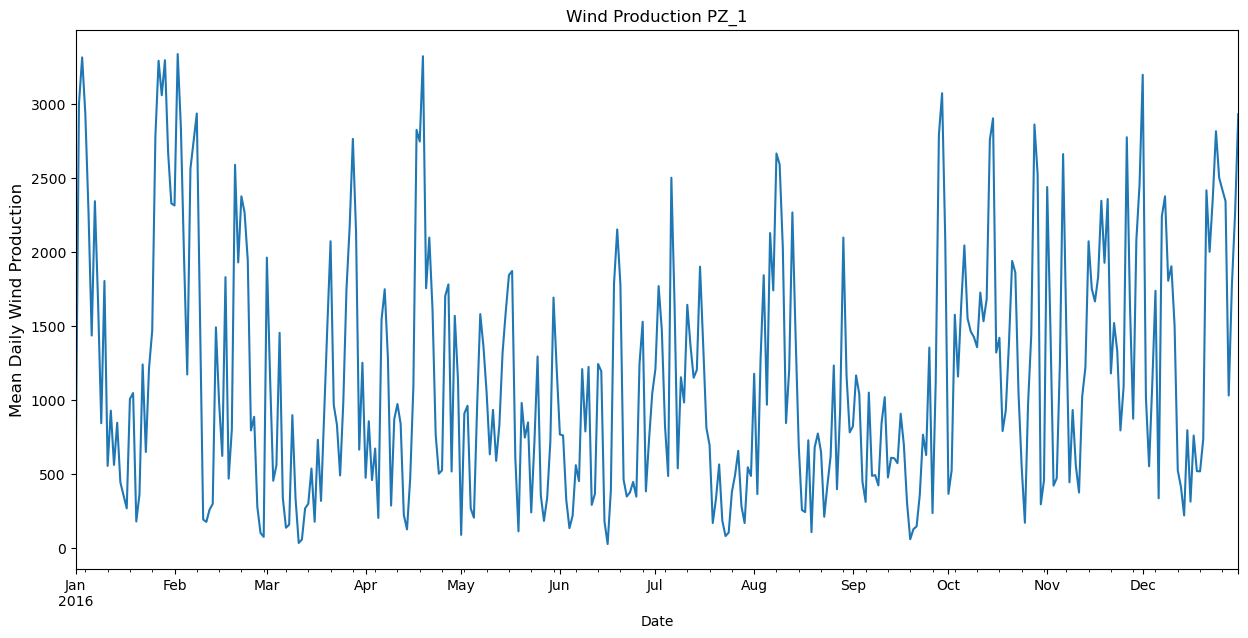

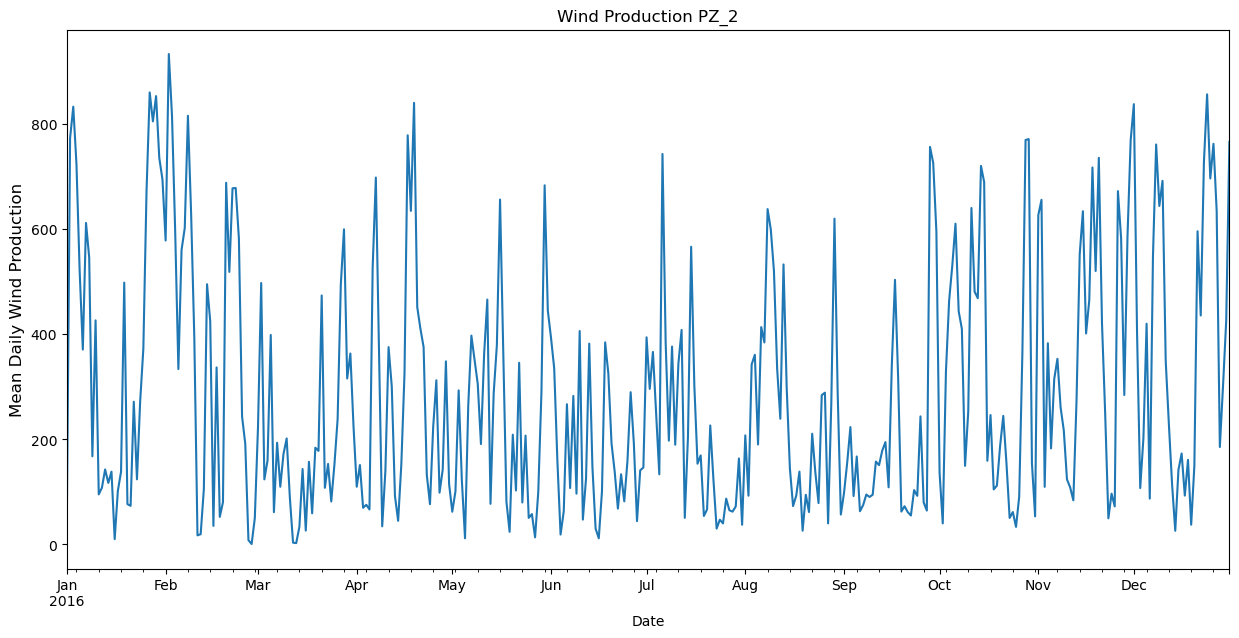

In [82]:
# Resampling daily 
plt.figure(figsize=(15,7))
plt.title('Wind Production PZ_1')
data['Wind Production PZ_1'].resample('D').mean().plot()
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.show()

plt.figure(figsize=(15,7))
plt.title('Wind Production PZ_2')
data['Wind Production PZ_2'].resample('D').mean().plot()
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.show()


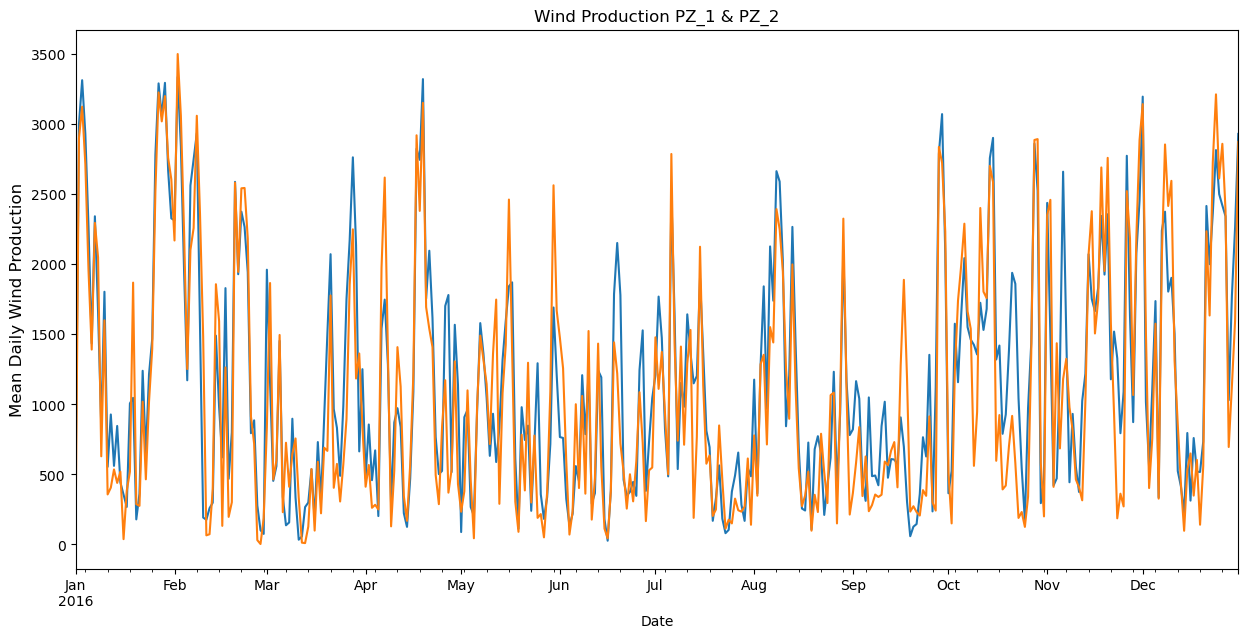

In [90]:
# plot combined with scaling
plt.figure(figsize=(15,7))
plt.title('Wind Production PZ_1 & PZ_2')
data['Wind Production PZ_1'].resample('D').mean().plot()
(data['Wind Production PZ_2']*3.75).resample('D').mean().plot()
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.show()


It is worth noting that the wind production from the two zones follow a very similar trend up to scaling.

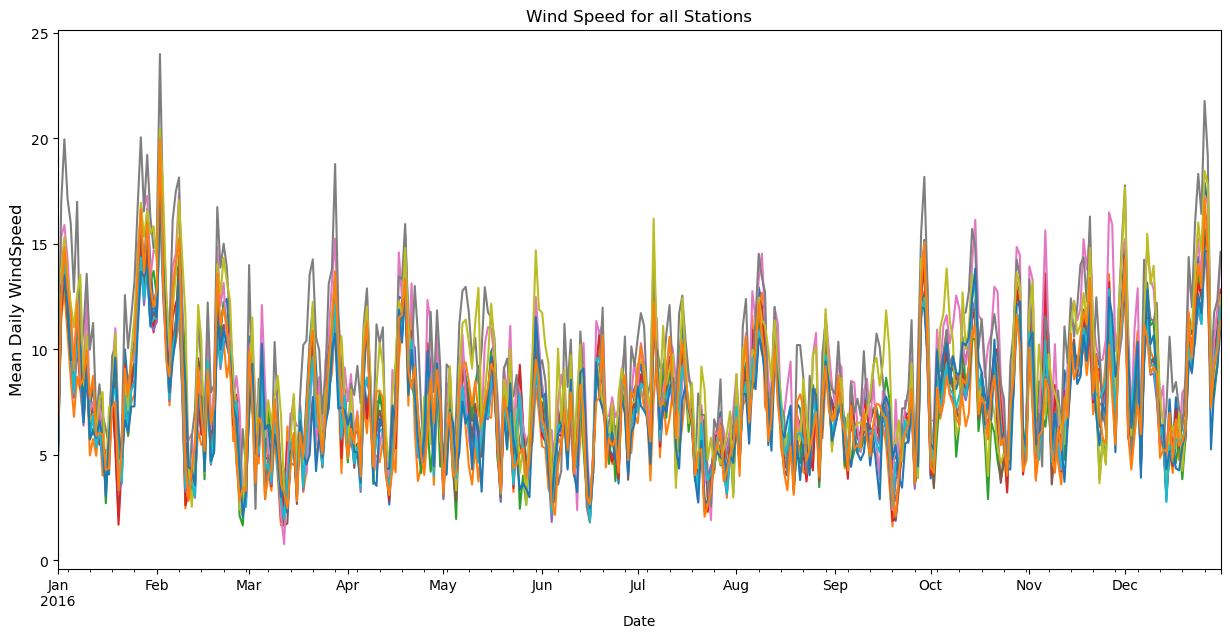

In [92]:
# plot speed for all stations
plt.figure(figsize=(15,7))
plt.title('Wind Speed for all Stations')
for i in range(1,13):
    data[f'Station{i}_WND'].resample('D').mean().plot()
plt.ylabel('Mean Daily WindSpeed', fontsize = 12)
plt.show()

In [ ]:
# plot speed for all stations
for i in range(1,13):
    plt.figure(figsize=(15,7))
    plt.title('Wind Speed for all Stations')
    data[f'Station{i}_WND'].resample('D').mean().plot()
    plt.ylabel('Mean Daily WindSpeed', fontsize = 12)
    plt.show()


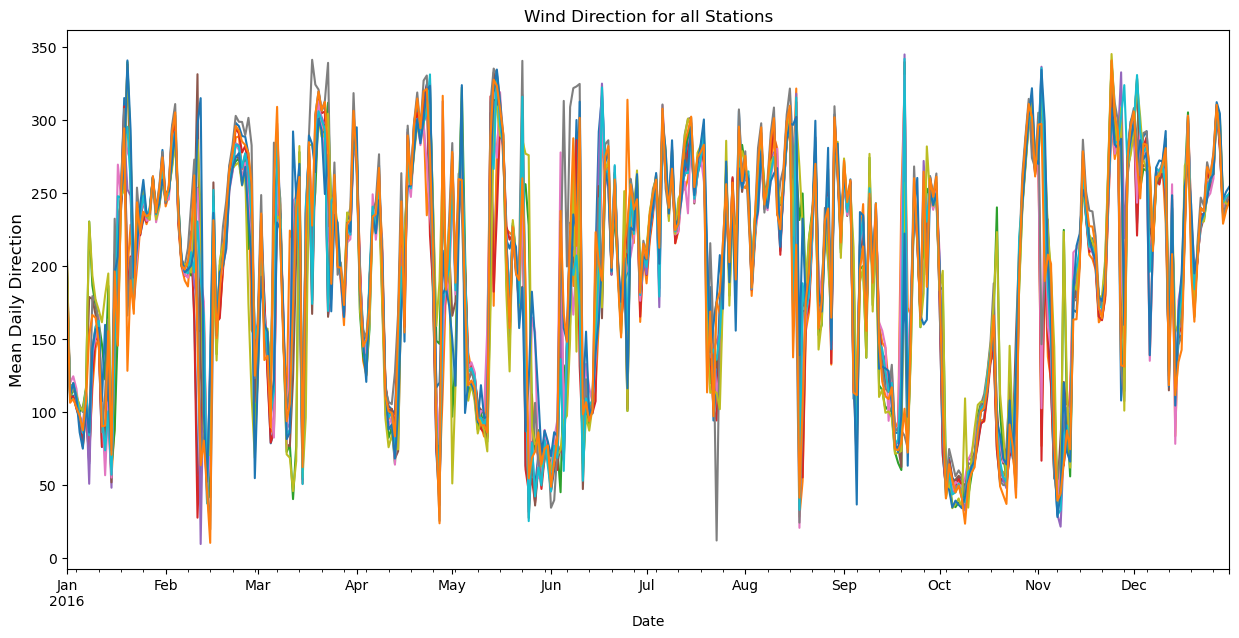

In [84]:
# plot direction for all stations
plt.figure(figsize=(15,7))
plt.title('Wind Direction for all Stations')
for i in range(1,13):
    data[f'Station{i}_DD'].resample('D').mean().plot()
plt.ylabel('Mean Daily Direction', fontsize = 12)
plt.show()

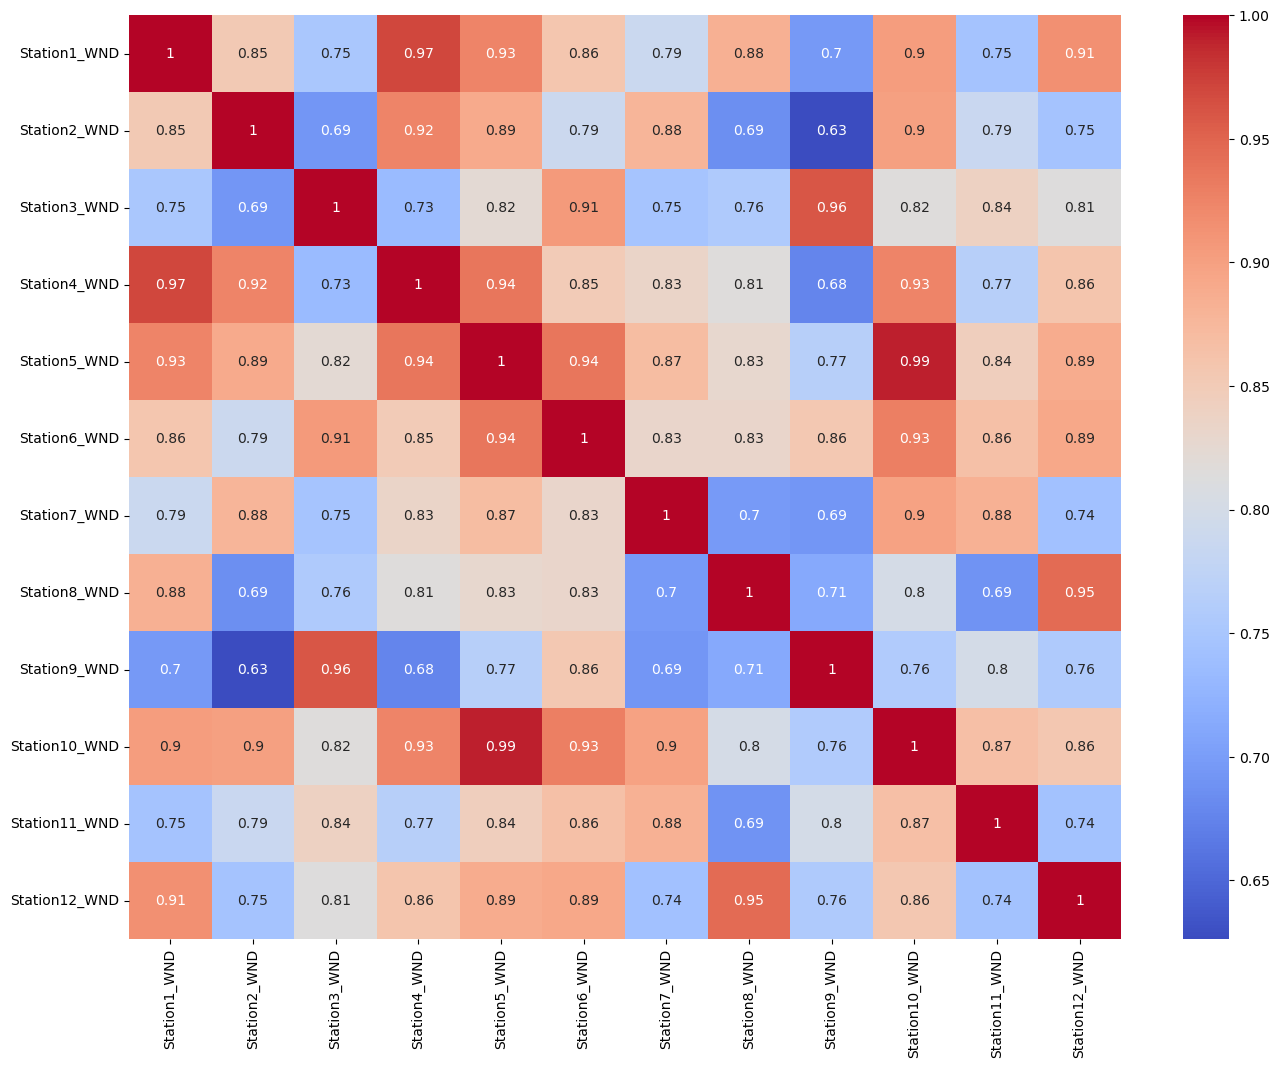

In [97]:
# Visualise correlation matrix
correlations = data[['Station1_WND','Station2_WND','Station3_WND','Station4_WND',
                     'Station5_WND','Station6_WND','Station7_WND','Station8_WND',
                     'Station9_WND','Station10_WND','Station11_WND','Station12_WND']].corr(method='pearson')
plt.figure(figsize = (16,12))
sns.heatmap(correlations, cmap='coolwarm', annot=True)
plt.show()